## Inicialización de los datos

In [5]:
# Precarga de todas las librerias necesarias para el proyecto

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pathlib import Path

In [10]:
# Definicion de las rutas de los archivos CSV a utilizar en el proyecto

BASE_DIR = Path().resolve()

data_path_0 = BASE_DIR / "data" / "geo_data_0.csv"
data_path_1 = BASE_DIR / "data" / "geo_data_1.csv"
data_path_2 = BASE_DIR / "data" / "geo_data_2.csv"

# Lectura y almacenamiento en dataframes de los CVS proporcionados 

geo_0 = pd.read_csv(data_path_0)
geo_1 = pd.read_csv(data_path_1)
geo_2 = pd.read_csv(data_path_2)

# Almacenamiento de los dataframes en una lista 

df_list = [geo_0, geo_1, geo_2]

# Asignacion de las variables necesarias para futuros calculos

BUDGET = 100000000 
N_WELLS = 200        
REVENUE_PER_UNIT  = 4500     
RISK_THRESHOLD = 2.5 
BOOTSTRAP_SAMPLES = 1000

# Calculo del minimo indispensable de unidades para evitar perdidas 

brake_event = (BUDGET / N_WELLS) / REVENUE_PER_UNIT

## Verificacion de integridad de los datos

In [11]:
# Consulta de datos generales geo_0, geo_1, geo_2

for df in df_list:
    print(df.info())

<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  str    
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), str(1)
memory usage: 3.8 MB
None
<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  str    
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), str(1)
memory usage: 3.8 MB
None
<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   -

In [12]:
# Impresion de muestra de geo_0, geo_1, geo_2

i = 1
for df in df_list:
    print(f"\nPozo: {i}\n")
    display(df.sample(5))
    i +=  1


Pozo: 1



,id,f0,f1,f2,product
15566,sacR2,1.078682,0.095846,-1.775019,27.821411
1122,nJAvK,1.018247,-0.429411,2.506254,123.018432
44833,u46v2,-0.289166,1.032955,4.730856,159.354644
98034,sWuaF,-0.018372,0.334635,-0.192986,94.174607
51939,0r1cg,0.470489,0.887989,0.082795,114.037848



Pozo: 2



,id,f0,f1,f2,product
47137,fDCop,9.310925,3.847196,4.993077,134.766305
46393,hIAnL,-3.893532,-11.847465,2.998596,84.038886
49625,f7b1F,8.855818,-1.453410,3.995759,107.813044
8092,BiIXT,20.141242,-4.148973,0.003065,0.000000
31434,UTqJP,12.821252,-2.528573,0.995792,26.953261



Pozo: 3



,id,f0,f1,f2,product
46488,Uolq3,0.128902,2.002579,3.260789,82.909784
38838,cc6Av,0.289078,-2.771596,5.131650,129.866889
26064,GKRvX,1.543879,0.787699,0.215558,36.255184
92957,H4U2A,-5.294862,3.322771,8.823126,186.781379
40881,B6eIV,-0.496236,-0.508560,-0.485917,30.873360


La obtencion de la muestra y consulta de informacion general de las bases de datos señala que estan listas para ser procesadas

## Construccion de funciones necesarias para el proyecto

### Pre_procesamiento

In [13]:
# Funcion de preposesamiento de datos

def pre_process(df):

    '''
    Filtra los dataframes para obtener las caracteristicas y objetivo, 
    ademas de crear los conjutos para entrenamiento y validacion a 75% y 25% respectivamente, 
    la funcion retornara 4 conjutos de datos (caracteristicas para entrenamiento, objetivo para entrenamiento, 
    caracterisitcas para validacion, objetivo para validacion)
    '''
     
    features = df.drop(['id', 'product'], axis=1)
    target = df['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features,
        target,
        test_size=0.25,
        random_state=12345
    )
    
    return features_train, features_valid, target_train, target_valid

### Modelado y entrenamiento

In [14]:
# Funcion para entrenamiento y prediccion de modelo 

def train_and_predict(features_train, features_valid, target_train):

    '''
    Se crea una instancia del metodo LinearRegression para poder entrenar un modelo de regresion lineal, 
    se genera la prediccion de los resultados con el modelo entrenado, la funcion retornara el conjunto de datos 
    obtendio en la prediccion
    '''
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = pd.Series(model.predict(features_valid), index=features_valid.index)
    return predictions

### Evaluacion

In [19]:
# Funcion para evaluar el modelo

def evaluate_model(target_true, target_pred):

    '''
    calcula el error cuadratico medio, retorna: el valor cuadratico medio y el valor promedio de la prediccion 
    '''
    
    rmse = mean_squared_error(target_true, target_pred)
    avg_predicted = target_pred.mean()
    return rmse, avg_predicted

### Calculo de ganancia

In [16]:
# Funcion para el calculo de la potencial ganacia 

def calculate_profit(y_true, y_pred):

    '''
    Obtiene los indices de los primeros 200 datos en orden descendente sobre el conjunto con predicciones, 
    usa de los indices obtenidos para filtrar el conjunto de validacion, calcula la ganacia con la formula: 
    ganancia = (num_total_barriles * ganancia_por_unidad) − presupuesto
    restorna: el valor de la ganacia para los 200 mejores pozos, total de undidades para los mejores 200 pozos, lista de los 200 mejores pozos
    '''
    
    top_200_idx = y_pred.sort_values(ascending=False).index[:N_WELLS]
    top_200 = y_true.loc[top_200_idx]
    total_units = top_200.sum()
    revenue = total_units * REVENUE_PER_UNIT
    profit = revenue - BUDGET
    return profit , total_units, top_200

### Bootstraping

In [17]:
# Funcion de bootstraping

def bootstrap_analysis(pred, valid, n_samples=BOOTSTRAP_SAMPLES):

    '''
    Creacion de muestras con reemplazo de conjunto de validacion y predecdio con entrenamiento de modelo,
    se genera una lista con el calculo de la de ganacia de las muestras obtenidas, calculo del promedio de las
    listas obtenias, obtencion del intervalo de confianza para el calculo del porcentaje de perdida, 
    retorna: promedio de ganancia, internvalo de confianza, probabilidad de perdida
    '''    

    state = np.random.RandomState(12345)
    profits = []
    n = len(valid)
    
    for _ in range(n_samples):

        sub_sample = valid.sample(n, replace=True, random_state=state).index
        pred_sub_sample = pred.loc[sub_sample]
        valid_sub_sample = valid.loc[sub_sample]
        prof, _, _ = calculate_profit(valid_sub_sample, pred_sub_sample)
        profits.append(prof)
        
    profits = pd.Series(profits)
        
    average_profit = profits.mean() 
    confidence_interval = np.percentile(profits, [2.5, 97.5])
    loss_probability = (profits < 0).mean() * 100
    
    return average_profit, confidence_interval, loss_probability

## Procesamiento de los datos

In [20]:
# Creacion de diccionario para almacenar los resultados del analisis 

results = {}
i = 0

# Bucle para iterar sobre los dataframes geo_0, geo_1, geo_3

for df in df_list:

    # Etapa de pre procesamiento de los datos con ayuda de la funcion pre_process()
    
    features_train, features_valid, target_train, target_valid = pre_process(df)

    # Etapa de entrenamiento y prediccion del modelo con ayuda de la funcion train_and_predict()
    
    target_pred = train_and_predict(features_train, features_valid, target_train) 

    target_pred = pd.Series(target_pred)

    # Calculo del error cuadratico medio y promedio de la prediccion con ayuda de la funcion evaluate_model()
    
    rmse, avg_predicted = evaluate_model(target_valid, target_pred)    

    # Comparacion de las reservas esperadas con la cantidad minima de reservas necesarias para evitar perdidas 

    avg_valid = target_valid.mean()
    if avg_valid >= brake_event:
        brake_event_res = "Reservas suficientes para evitar perdida"
    else: brake_event_res = "Reservas insuficientes para evitar perdida"

    # Calculo de la ganancia esperada, cantidad de barriles y canitdad de barriles promedio de los 200 pozos con mejor rendimiento

    total_production, t_units, top_200 = calculate_profit(target_valid, target_pred)
    avg_production = top_200.mean()

    # Implementacion de tecnica de bootstraping 
    
    avg_profit_btp, conf_interval, loss_prob = bootstrap_analysis(target_pred, target_valid)

    # Captura de los valores obtenidos en el diccionario results{} 

    results[f"geo_{i}"] = {
        'reserves_comparation': brake_event_res,
        'avg_reserves': avg_valid,
        'rmse': rmse,
        'avg_predicted': avg_predicted,
        'total_production': t_units,
        'avg_actual_production': avg_production,
        'point_profit': total_production,
        'average_profit_btp': avg_profit_btp,
        'confidence_interval': conf_interval,
        'loss_probability': loss_prob,
        'risk_threshold': RISK_THRESHOLD,
        'brake_event' : brake_event
    }
    
    i += 1

results_df = pd.DataFrame.from_dict(results, orient="index").rename_axis("region").reset_index()
ci = results_df.pop("confidence_interval").apply(pd.Series)
results_df[["ci_low","ci_high"]] = ci

display(results_df)

,region,reserves_comparation,avg_reserves,rmse,avg_predicted,total_production,avg_actual_production,point_profit,average_profit_btp,loss_probability,risk_threshold,brake_event,ci_low,ci_high
0,geo_0,Reservas insuficientes para evitar perdida,92.078597,1412.212936,92.592568,29601.835651,148.009178,3.320826e+07,1.665821e+08,0.0,2.5,111.111111,1.342652e+08,2.018526e+08
1,geo_1,Reservas insuficientes para evitar perdida,68.723136,0.797626,68.728547,27589.081548,137.945408,2.415087e+07,1.480683e+08,0.0,2.5,111.111111,1.209730e+08,1.787187e+08
2,geo_2,Reservas insuficientes para evitar perdida,94.884233,1602.377581,94.965046,28245.222141,141.226111,2.710350e+07,1.543364e+08,0.0,2.5,111.111111,1.232286e+08,1.889631e+08


## Reperesentacion de los resultados

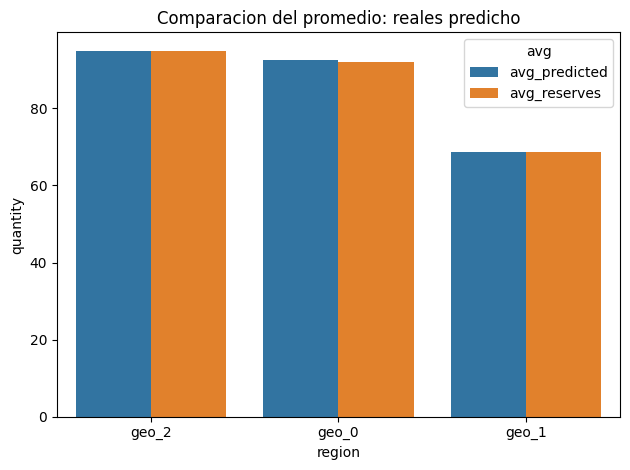

In [21]:
# Ajuste del la base de datos a formato largo para facilitar el graficado 

long = results_df.melt(id_vars="region", value_vars=["avg_predicted", "avg_reserves"],
                       var_name="avg", value_name="quantity").sort_values("quantity", ascending=False)

# Dibujado de la grafica representativa

ax = sns.barplot(data=long, x='region', y='quantity', hue='avg')
ax.set_title("Comparacion del promedio: reales predicho")

plt.tight_layout()
plt.show()


No hay una diferencia significativa en el numero de barriles esperados contra el numero de barriles reales. Es importante resaltar que **el umbral minimo para evitar perdidas (111 barriles), no fue alcanzado por ninguna region.**

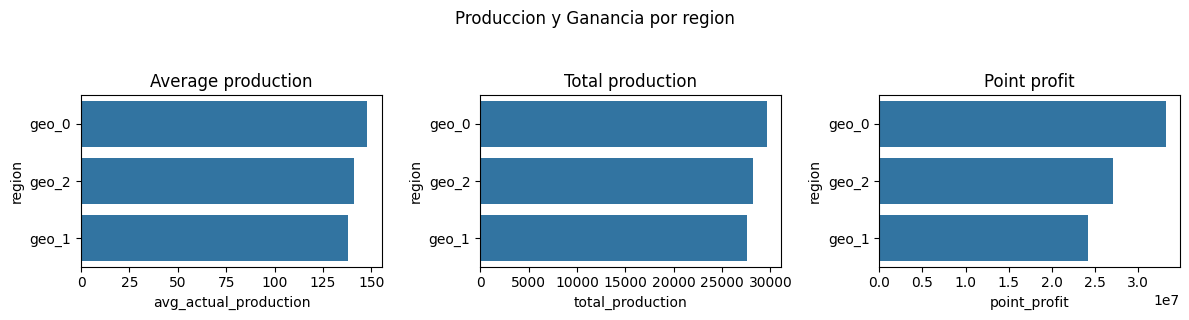

In [24]:
# Visuales de produccion y ganancia

results_df = results_df.sort_values("total_production", ascending=False)
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=False, sharey=False)

sns.barplot(data=results_df, x="total_production", y="region", ax=axes[1])
axes[1].set_title("Total production")

sns.barplot(data=results_df, x="avg_actual_production", y="region", ax=axes[0])
axes[0].set_title("Average production")

sns.barplot(data=results_df, x="point_profit", y="region", ax=axes[2])
axes[2].set_title("Point profit")

fig.suptitle("Produccion y Ganancia por region", y=1.05, fontsize=12)
plt.tight_layout()
plt.show()

Los datos arrojan que la region 'geo_0' tiene el mayor indice de produccion, por ende, mayor ganacia puntual

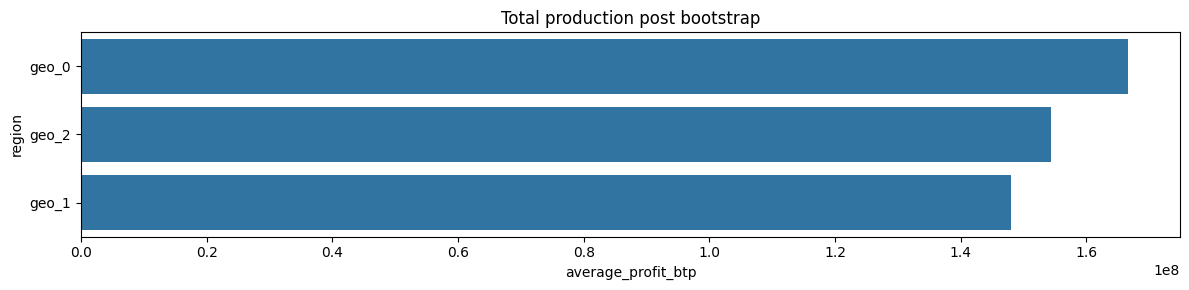

In [25]:
# Visuales para ganancia con bootstraping

fig, ax = plt.subplots(figsize=(12, 3))
sns.barplot(data=results_df, x="average_profit_btp", y="region", ax=ax)
ax.set_title("Total production post bootstrap")
plt.tight_layout()
plt.show()

Despues del analisis con tecnica de bootstraping, vamos que la zona con mejor rendimiento es geo_0

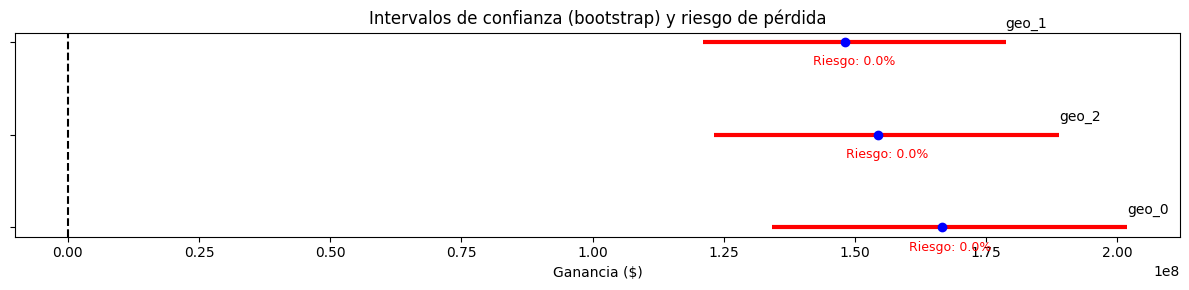

In [26]:
# Visuales del intervalo de confianza

fig, ax = plt.subplots(figsize=(12, 3))
for y, row in enumerate(results_df.itertuples(index=False)):
    # Dibujamos el intervalo 95% como línea roja
    ax.hlines(y=y, xmin=row.ci_low, xmax=row.ci_high, color="red", linewidth=3)
    # Marcamos la ganancia promedio con un punto
    ax.plot(row.average_profit_btp, y, "o", color="blue")
    # Etiquetas con región y riesgo
    ax.text(row.ci_high, y + 0.15, f"{row.region}", fontsize=10)
    ax.text((row.ci_low + row.ci_high)/2, y - 0.25,
            f"Riesgo: {row.loss_probability:.1f}%",
            ha="center", fontsize=9, color="red")
ax.axvline(0, color="black", linestyle="--")
ax.set_xlabel("Ganancia ($)")
ax.set_yticks(range(len(results_df)))
ax.set_yticklabels([])
ax.set_title("Intervalos de confianza (bootstrap) y riesgo de pérdida")
plt.tight_layout()
plt.show()

Todas las zonas estan por debajo del umbral propuesto para seleccionar al mejor candidato (2.5%). Por lo que, considerando la zona con mayor rendimiento posible, tenemos como mejor candidato a la region 0 con una ganancia media de 1.6 millones

## Concluciones

A pesar de que el analisis con respecto a la cantidad minima de reservas arrojo que no hay suficientes para evitar la perdida, tenemos que **la region 0 es la mas productiva**. Ninguna zona arroja riesgo de perdida aparente despues del analisis con bootstraping y aunque la produccion actual sea ligeramente mayor en la region 2, la prediccion señala una mayor cantidad de barriles para la zona 0, lo que, refuerza la seleccion de la region 0 cero como mejor opcion. 